## Model and Feature Selection

In [90]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPool2D
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras import backend as K

In [91]:
# read the csv with MA data
df = pd.read_csv('data/log_per_student.csv')

c:\users\anel akiyanova\anaconda3\envs\february\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [92]:
df.head(2)

,leaid,name,stabbr,agchrt,v33,totalrev,tfedrev,c14,c15,c16,...,w01,w31,w61,v95,v02,k14,ce1,ce2,ce3,graduation rate
0,<<<<<<< HEAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2700001,MOUNTAIN IRON-BUHL,MN,3.0,507.0,9.684527,6.770554,5.84403,0.0,3.244194,...,6.04522,0.0,10.269527,5.972549,4.529392,5.201033,0.0,0.0,0.0,0.9355


In [93]:
df.columns = df.columns.str.lower() #make column names lower-case

In [94]:
df.set_index(df['leaid'], inplace = True) #set leaid column as index

In [95]:
dummies = pd.get_dummies(df['agchrt'], drop_first = True).astype('float64') # dummify agchrt column

In [96]:
df = pd.concat([df, dummies], axis = 1) # add to the dataframe

In [97]:
df.isnull().sum() # check for null values

leaid              0
name               3
stabbr             3
agchrt             3
v33                3
                  ..
ce2                3
ce3                3
graduation rate    3
2.0                0
3.0                0
Length: 133, dtype: int64

In [110]:
df.dropna(axis = 0, inplace = True) #drop null values

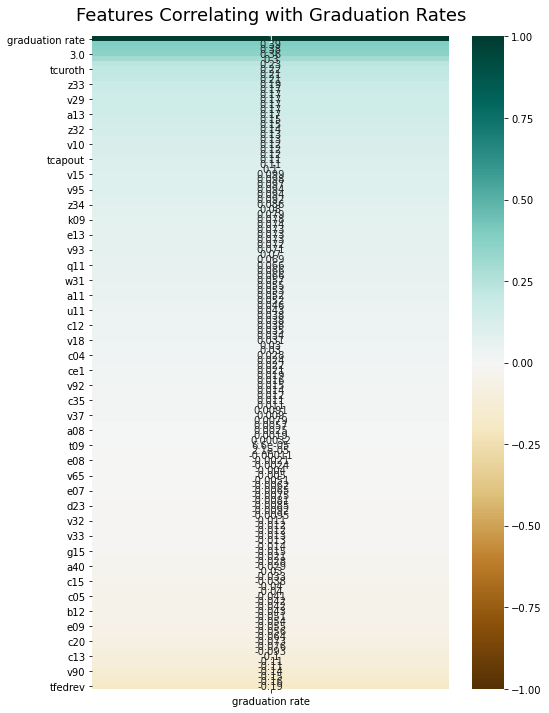

In [108]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['graduation rate']].sort_values(by='graduation rate', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Graduation Rates', fontdict={'fontsize':18}, pad=16);

### Define X and y

In [111]:
# numeric X Features (excl stabbr)
X = df[[2, 3,'tfedrev', 'tstrev', 'a13', 't06', 'a11', 'u30', 'totalexp', 't40', 
        'v93', 'z33', 'z35', 'z36', 'z38', 'z37', 'v11', 'v13', 'v17', 'v37', 'v10', 'v12', 'v14', 
        'v18', 'v24', 'v38', 'w01', 'w31', 'w61', '_19h', '_21f', '_41f', '_61v']]

y = df['graduation rate']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y) #train test split the variables

In [113]:
# data types (the only object is district name column)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16848 entries, 3103420 to 5306240
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   2.0       16848 non-null  float64
 1   3.0       16848 non-null  float64
 2   tfedrev   16848 non-null  float64
 3   tstrev    16848 non-null  float64
 4   a13       16848 non-null  float64
 5   t06       16848 non-null  float64
 6   a11       16848 non-null  float64
 7   u30       16848 non-null  float64
 8   totalexp  16848 non-null  float64
 9   t40       16848 non-null  float64
 10  v93       16848 non-null  float64
 11  z33       16848 non-null  float64
 12  z35       16848 non-null  float64
 13  z36       16848 non-null  float64
 14  z38       16848 non-null  float64
 15  z37       16848 non-null  float64
 16  v11       16848 non-null  float64
 17  v13       16848 non-null  float64
 18  v17       16848 non-null  float64
 19  v37       16848 non-null  float64
 20  v10       16848 non-null 

#### Heatmap of numeric features

In [103]:
# creating a dataframe of features
feature_df = df[[2, 3,'tfedrev', 'tstrev', 'a13', 't06', 'a11', 'u30', 'totalexp', 't40', 
        'v93', 'z33', 'z35', 'z36', 'z38', 'z37', 'v11', 'v13', 'v17', 'v37', 'v10', 'v12', 'v14', 
        'v18', 'v24', 'v38', 'w01', 'w31', 'w61', '_19h', '_21f', '_41f', '_61v']]

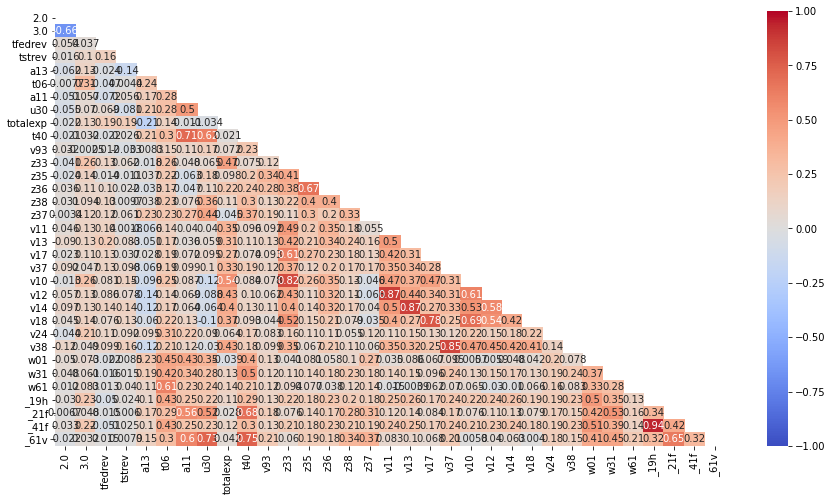

In [104]:
# plotting a heatmap / test for collinearity
mask = np.zeros_like(feature_df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 8))
sns.heatmap(
    feature_df.corr(),
    cmap='coolwarm',
    annot=True,
    mask = mask,
    vmin = -1.,
    vmax = 1.
    
);

### Neural Networks

In [116]:
sscaler = StandardScaler() 

In [117]:
X_train_scaled = sscaler.fit_transform(X_train) #scale X_train

In [118]:
X_test_scaled = sscaler.transform(X_test) #scale X_test

In [119]:
# build a network 
model = Sequential()
model.add(Dense(200, kernel_initializer='normal',input_dim = X_train_scaled.shape[1], activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [120]:
# compile the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

In [121]:
# fit the data
history = model.fit( 
    X_train_scaled,
    y_train,
    validation_data = (X_test_scaled, y_test),
    epochs = 35,
    verbose = 0
)

In [122]:
# evaluate the model
nn_model = model.evaluate(X_test_scaled, y_test)

176/176 [==============================] - 0s 2ms/step - loss: 0.0105 - mse: 0.0105


In [126]:
# rmse of the model with regularization
np.round(np.sqrt(nn_model), 4)

array([0.1026, 0.1026])

In [123]:
predictions = model.predict(X_test_scaled) # predictions

In [125]:
# r-squared score
r2_score(y_test, predictions)

0.3085270333614927

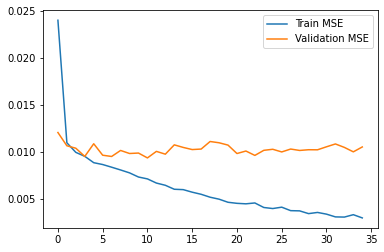

In [127]:
plt.plot(history.history['mse'], label = 'Train MSE')
plt.plot(history.history['val_mse'], label = 'Validation MSE')
plt.legend();